# Week 4: Multi-class Classification

Welcome to this assignment! In this exercise, you will get a chance to work on a multi-class classification problem. You will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the English alphabet. 

You will need to pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.


Let's get started!

_**NOTE:** To prevent errors from the autograder, please avoid editing or deleting non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

In [1]:
# grader-required-cell

import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import pandas as pd

Download the training and test sets (the test set will actually be used as a validation set):

The data for this exercise is available at: https://www.kaggle.com/datamunge/sign-language-mnist/home

Define some globals with the path to both files you just downloaded:

In [2]:
# grader-required-cell

TRAINING_FILE = './sign mnist/sign_mnist_train/sign_mnist_train.csv'
VALIDATION_FILE = './sign mnist/sign_mnist_test/sign_mnist_test.csv'

Unlike previous assignments, you will not have the actual images provided, instead you will have the data serialized as `csv` files.

Take a look at how the data looks like within the `csv` file:

In [3]:
# grader-required-cell
training_df = pd.read_csv(TRAINING_FILE)
val_df = pd.read_csv(VALIDATION_FILE)

print(training_df.shape)
print(val_df.shape)
print(training_df['label'].nunique())
training_df.head()

(27455, 785)
(7172, 785)
24


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
training_images = training_df.drop(['label'], axis=1).to_numpy()
training_images = np.reshape(training_images, (27455,28,28))
training_images = training_images.astype(float)
training_labels = training_df['label']
training_labels = training_labels.astype(float)


validation_images = val_df.drop(['label'], axis=1).to_numpy()
validation_images = np.reshape(validation_images, (7172,28,28))
validation_images = validation_images.astype(float)
validation_labels = val_df['label']
validation_labels = validation_labels.astype(float)


As you can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values. 

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

In [5]:


print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


**Expected Output:**
```
Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64
```

## Visualizing the numpy arrays

Now that you have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like:

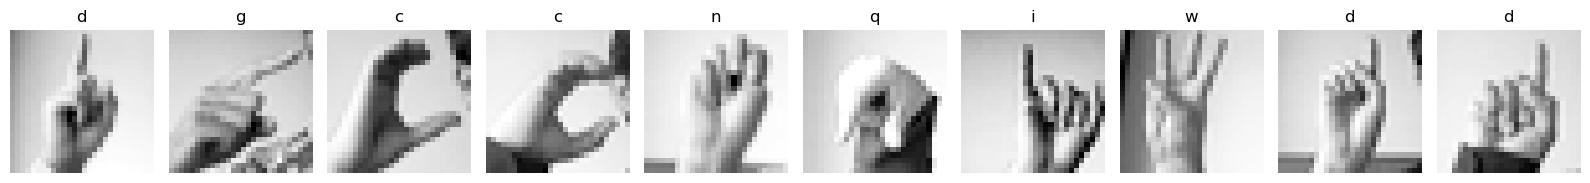

In [6]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this complete the `train_val_generators` function below.

Some important notes:

- The images in this dataset come in the same resolution so you don't need to set a custom `target_size` in this case. In fact, you can't even do so because this time you will not be using the `flow_from_directory` method (as in previous assignments). Instead you will use the [`flow`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow) method.
- You need to add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images). Take a look at the function [`np.expand_dims`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) for this.

In [8]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators
  
  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE
    
  #One hot encode labels:
  training_labels = tf.keras.utils.to_categorical(training_labels, num_classes =26)
  validation_labels = tf.keras.utils.to_categorical(validation_labels, num_classes =26)    

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
  training_images = np.expand_dims(training_images, axis =3)
  validation_images = np.expand_dims(validation_images, axis =3)

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values 
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                    rotation_range=40,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest',
                                    horizontal_flip=True
                                    )


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1.0/255. )

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  ### END CODE HERE

  return train_generator, validation_generator

In [9]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455, 26)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172, 26)


**Expected Output:**
```
Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)
```

## Coding the CNN

One last step before training is to define the architecture of the model.

Complete the `create_model` function below. This function should return a Keras' model that uses the `Sequential` or the `Functional` API.

The last layer of your model should have a number of units equal to the number of letters in the English alphabet. It should also use an activation function that will output the probabilities per letter.

*Note: The [documentation](https://www.kaggle.com/datamunge/sign-language-mnist) of the dataset mentions that there are actually no cases for the last letter, Z, and this will allow you to reduce the recommended number of output units above by one. If you're not yet convinced, you can safely ignore this fact for now and study it later. You will pass the assignment even without this slight optimization.*

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is suitable for multi-class classification.

**Note that you should use no more than 2 Conv2D and 2 MaxPooling2D layers to achieve the desired performance.**

In [10]:
# grader-required-cell

def create_model():

  ### START CODE HERE       

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (2,2), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, activation = 'relu'),
      tf.keras.layers.Dense(26, activation = 'softmax')
  ])
  
    # could also just use sparse_categorical_crossentropy instead of one-hot-encoding
  model.compile(optimizer = 'rmsprop' ,
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE       
  
  return model

In [11]:
# Save your model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

In [12]:
# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 11s 12ms/step - loss: 3.0356 - accuracy: 0.0963 - val_loss: 2.5199 - val_accuracy: 0.2172
Epoch 2/15
858/858 [==============================] - 10s 12ms/step - loss: 2.6199 - accuracy: 0.1975 - val_loss: 2.4236 - val_accuracy: 0.2179
Epoch 3/15
858/858 [==============================] - 10s 12ms/step - loss: 2.3403 - accuracy: 0.2712 - val_loss: 1.8821 - val_accuracy: 0.3650
Epoch 4/15
858/858 [==============================] - 10s 12ms/step - loss: 2.1139 - accuracy: 0.3354 - val_loss: 1.5728 - val_accuracy: 0.4721
Epoch 5/15
858/858 [==============================] - 10s 12ms/step - loss: 1.8956 - accuracy: 0.3933 - val_loss: 1.3263 - val_accuracy: 0.5319
Epoch 6/15
858/858 [==============================] - 10s 12ms/step - loss: 1.7140 - accuracy: 0.4494 - val_loss: 1.2477 - val_accuracy: 0.5623
Epoch 7/15
858/858 [==============================] - 10s 12ms/step - loss: 1.5522 - accuracy: 0.4954 - val_loss: 0.8832 - val_accuracy:

Now take a look at your training history:

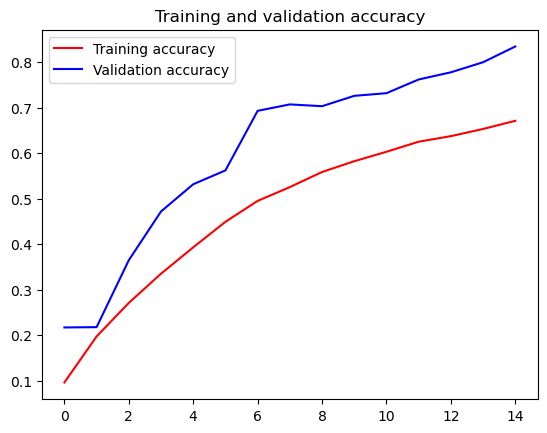

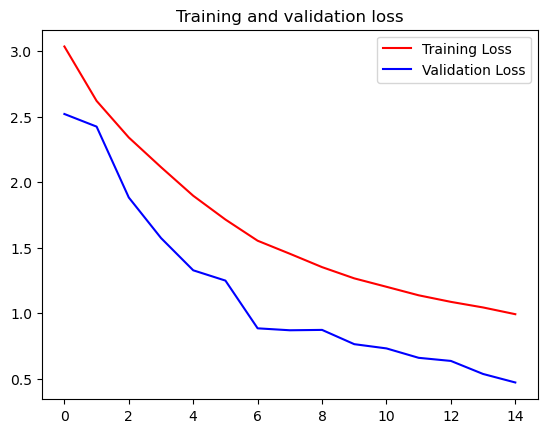

In [13]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that is able to perform multi-class classification tasks! Nice job!

**Keep it up!**